<a href="https://colab.research.google.com/github/nana-lyj/testtt/blob/main/aaaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets scikit-learn imbalanced-learn sentence-transformers tensorflow

In [51]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# 加载数据集（包含所有拆分）
dataset = load_dataset("nanaaaa/BilingualChildEmo")

# 查看可用拆分
print("数据集包含的拆分:", dataset.keys())  # 通常为 ['train', 'validation', 'test']

# 1. 处理训练集
train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]

# 2. 处理验证集（如果存在）
if "dev" in dataset:
    val_texts = dataset["dev"]["sentence"]
    val_labels = dataset["dev"]["label"]
else:
    # 若无验证集，从训练集划分
    from sklearn.model_selection import train_test_split
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels,
        test_size=0.2,
        random_state=42,
        stratify=train_labels
    )

# 3. 处理测试集（必须存在）
test_texts = dataset["test"]["sentence"]
test_labels = dataset["test"]["label"]

# SBERT嵌入（统一处理所有数据）
sbert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

X_train = sbert.encode(train_texts, show_progress_bar=True)
X_val = sbert.encode(val_texts, show_progress_bar=True) if "val_texts" in locals() else None
X_test = sbert.encode(test_texts, show_progress_bar=True)

y_train = np.array(train_labels)
y_val = np.array(val_labels) if "val_labels" in locals() else None
y_test = np.array(test_labels)

数据集包含的拆分: dict_keys(['train', 'validation', 'test'])


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier  # TF < 2.6

def create_model():
    model = Sequential([
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)
model.fit(X_train, y_train)

# 1. 标签和权重设置（保持与RF一致）
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']
classes = np.unique(y_train_encoded)
class_weights = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train_encoded)))
class_weights[4] = 3.0  # 增强'love'权重

# 2. 神经网络构建函数
def create_model(units1=256, units2=128, dropout=0.3, lr=0.001):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout),
        Dense(units2, activation='relu'),
        Dense(len(label_names), activation='softmax')
    ])
    model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 3. 参数网格和搜索
param_grid = {
    'units1': [128, 256],
    'units2': [64, 128],
    'dropout': [0.2, 0.3],
    'lr': [0.001, 0.0005],
    'batch_size': [64, 128],
    'epochs': [50]
}

grid_nn = GridSearchCV(
    KerasClassifier(create_model, verbose=0),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2
)

# 4. 训练和评估
grid_nn.fit(X_train, y_train_encoded, class_weight=class_weights)
best_nn = grid_nn.best_estimator_
y_pred = best_nn.predict(X_test)

# 5. 输出结果（保持RF相同格式）
print("\n最佳参数:", grid_nn.best_params_)
print("\n测试集分类报告:")
print(classification_report(y_test_encoded, y_pred, target_names=label_names, digits=3))

# 6. 各类别F1分数
print("\n各类别F1分数:")
for cls, name in enumerate(label_names):
    cls_mask = (y_test_encoded == cls)
    if sum(cls_mask) > 0:
        f1 = f1_score(y_test_encoded[cls_mask], y_pred[cls_mask], average='binary')
        print(f"{name}: {f1:.3f} (样本数: {sum(cls_mask)})")

# 7. 可视化（与RF相同风格）
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test_encoded, y_pred),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.show()

# 8. 保存模型
best_nn.model.save('best_nn_model.h5')

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers.scikit_learn'

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2510 - loss: 1.6828 - val_accuracy: 0.4754 - val_loss: 1.3021
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5471 - loss: 1.2692 - val_accuracy: 0.5410 - val_loss: 1.1043
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6252 - loss: 1.0395 - val_accuracy: 0.5803 - val_loss: 1.0623
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6594 - loss: 0.8765 - val_accuracy: 0.6361 - val_loss: 1.0043
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7434 - loss: 0.7905 - val_accuracy: 0.6000 - val_loss: 0.9954
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7268 - loss: 0.7727 - val_accuracy: 0.6295 - val_loss: 0.9811
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7473 - loss: 0.6789 - val_accuracy: 0.6361 - val_loss: 0.9757
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8072 - loss: 0.5742 - val_accuracy: 0.6328 - val_l

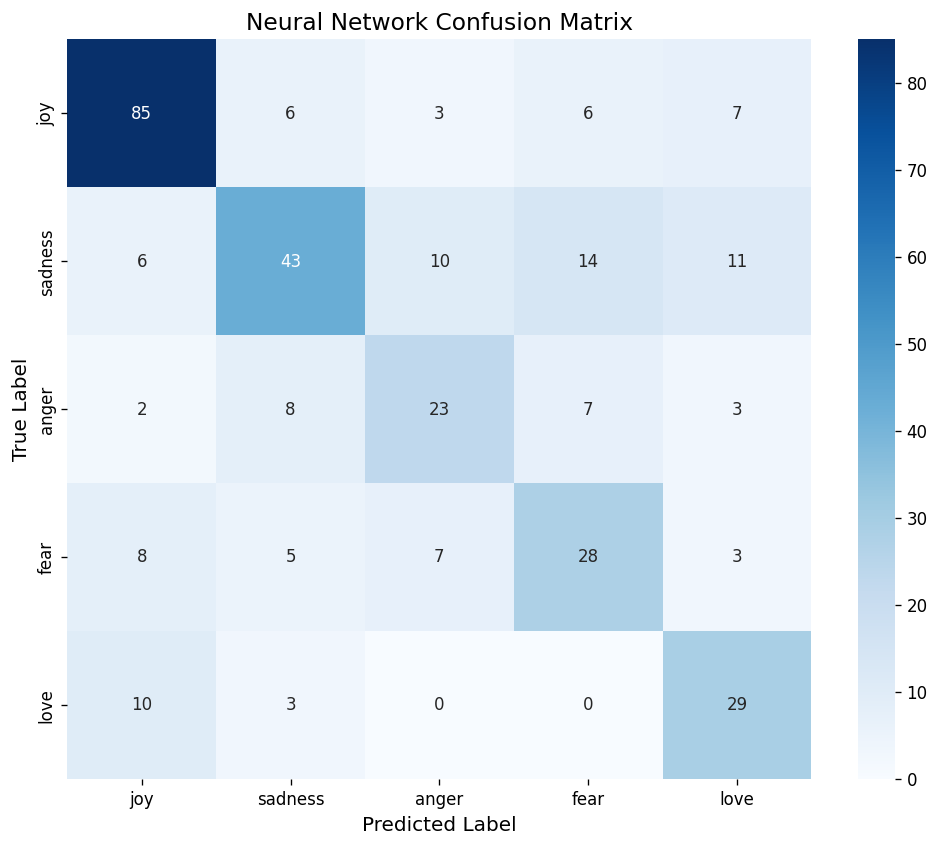

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. 定义模型（比随机森林更简洁）
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(len(label_names), activation='softmax')
])

# 2. 编译模型
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. 训练（比GridSearchCV更直观）
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=5)]
)

# 4. 评估（保持与随机森林相同输出格式）
y_pred_nn = model.predict(X_test).argmax(axis=1)
print("\n神经网络测试集分类报告:")
print(classification_report(
    y_test_encoded,
    y_pred_nn,
    target_names=label_names,
    digits=3
))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# [...] 前面是您的模型训练代码（保持原样）

# 1. 预测测试集
y_pred = model.predict(X_test).argmax(axis=1)

# 2. 计算混淆矩阵
cm = confusion_matrix(y_test_encoded, y_pred)

# 3. 绘制热力图（与随机森林完全一致风格）
plt.figure(figsize=(10, 8), dpi=120)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',  # 显示整数
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Neural Network Confusion Matrix', fontsize=14)
plt.show()

In [42]:
from sklearn.preprocessing import LabelEncoder

# 1. 标签编码
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 确保验证集存在
if "val_texts" in locals() and val_texts is not None:
    y_val_encoded = label_encoder.transform(y_val)
    validation_data = (X_val, y_val_encoded)
else:
    validation_data = None

# 2. 定义标签名称（从数据集中获取唯一标签）
label_names = label_encoder.classes_
print("检测到的标签类别:", label_names)

# 3. 计算类别权重
class_weights = {}
total_samples = len(y_train_encoded)
for cls in np.unique(y_train_encoded):
    cls_samples = sum(y_train_encoded == cls)
    weight = (total_samples / (len(np.unique(y_train_encoded)) * cls_samples))
    class_weights[cls] = weight

print("\n类别权重分配：")
for cls, weight in class_weights.items():
    print(f"{label_names[cls]}: {weight:.2f}")

# 4. 构建模型（保持您的原始模型结构）
def build_model(input_shape, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 5. 初始化模型
model = build_model(input_shape=(X_train.shape[1],), n_classes=len(label_names))
model.summary()

# 6. 训练配置
early_stop = EarlyStopping(
    monitor='val_loss' if validation_data else 'loss',
    patience=10,
    restore_best_weights=True
)

# 7. 模型训练
history = model.fit(
    X_train, y_train_encoded,
    validation_data=validation_data,
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# 8. 评估模型
if X_test is not None:
    y_pred = model.predict(X_test).argmax(axis=-1)
    print("\n测试集分类报告:")
    print(classification_report(
        y_test_encoded,
        y_pred,
        target_names=label_names,
        digits=3
    ))

检测到的标签类别: [0 1 2 3 4]

类别权重分配：
0: 0.57
1: 0.81
2: 1.35
3: 1.30
4: 1.95


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,637 (522.02 KB)

 Trainable params: 132,869 (519.02 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2824 - loss: 2.1206 - val_accuracy: 0.4656 - val_loss: 1.4469
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5948 - loss: 1.0180 - val_accuracy: 0.5279 - val_loss: 1.3559
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6948 - loss: 0.8228 - val_accuracy: 0.5705 - val_loss: 1.3097
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7429 - loss: 0.7447 - val_accuracy: 0.6000 - val_loss: 1.2567
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7724 - loss: 0.5958 - val_accuracy: 0.6328 - val_loss: 1.1977
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7914 - loss: 0.5451 - val_accuracy: 0.6230 - val_loss: 1.1651
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8228 - loss: 0.4832 - val_accuracy: 0.6197 - val_loss: 1.1292
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8269 - loss: 0.4497 - val_accuracy: 0.

TypeError: object of type 'numpy.int64' has no len()

In [46]:
# 6. 输出最佳参数
print("\n最佳参数组合:", grid_nn.best_params_)
best_nn = grid_nn.best_estimator_



# 7. 测试集评估
y_pred_nn = best_nn.predict(X_test)
print("\n神经网络测试集分类报告:")
print(classification_report(
    y_test_encoded,
    y_pred_nn,
    target_names=label_names,
    digits=3
))

# 8. 混淆矩阵可视化
conf_mat = confusion_matrix(y_test_encoded, y_pred_nn)
plt.figure(figsize=(10, 8), dpi=120)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.show()

# 9. 训练曲线可视化（需要从history对象获取）
history = best_nn.model.history.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

NameError: name 'grid_nn' is not defined

In [44]:
# 确保 label_names 是字符串列表
if all(isinstance(x, (int, float, np.integer)) for x in label_encoder.classes_):
    label_names = [f"class_{int(x)}" for x in label_encoder.classes_]
else:
    label_names = [str(x) for x in label_encoder.classes_]

# 评估模型
if X_test is not None:
    y_pred = model.predict(X_test).argmax(axis=-1)
    print("\n测试集分类报告:")
    print(classification_report(
        y_test_encoded,
        y_pred,
        target_names=label_names,
        digits=3
    ))

    # 可选：打印混淆矩阵
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    print("混淆矩阵:")
    print(cm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

测试集分类报告:
              precision    recall  f1-score   support

     class_0      0.718     0.785     0.750       107
     class_1      0.607     0.607     0.607        84
     class_2      0.463     0.442     0.452        43
     class_3      0.489     0.451     0.469        51
     class_4      0.579     0.524     0.550        42

    accuracy                          0.609       327
   macro avg      0.571     0.562     0.566       327
weighted avg      0.603     0.609     0.605       327

混淆矩阵:
[[84  9  4  6  4]
 [ 9 51  8 11  5]
 [ 4 11 19  7  2]
 [ 8  8  7 23  5]
 [12  5  3  0 22]]


In [43]:
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']  # 示例

print("原始标签示例:", train_labels[:5])
print("编码后标签示例:", y_train_encoded[:5])
print("LabelEncoder classes:", label_encoder.classes_)

label_names = list(label_encoder.classes_)

原始标签示例: [2, 4, 1, 1, 0]
编码后标签示例: [2 4 1 1 0]
LabelEncoder classes: [0 1 2 3 4]


In [23]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# 加载数据集（包含所有拆分）
dataset = load_dataset("nanaaaa/BilingualChildEmo")

# 查看可用拆分
print("数据集包含的拆分:", dataset.keys())  # 通常为 ['train', 'validation', 'test']

# 1. 处理训练集
train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]



# 3. 处理测试集（必须存在）
test_texts = dataset["test"]["sentence"]
test_labels = dataset["test"]["label"]

# SBERT嵌入（统一处理所有数据）
sbert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

X_train = sbert.encode(train_texts, show_progress_bar=True)
X_val = sbert.encode(val_texts, show_progress_bar=True) if "val_texts" in locals() else None
X_test = sbert.encode(test_texts, show_progress_bar=True)

y_train = np.array(train_labels)
y_val = np.array(val_labels) if "val_labels" in locals() else None
y_test = np.array(test_labels)

数据集包含的拆分: dict_keys(['train', 'validation', 'test'])


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [29]:
from sklearn.svm import SVC

# 直接使用原始划分的数据
model = SVC(class_weight='balanced')
model.fit(X_train, y_train)

# 在验证集调参（如果存在）
if X_val is not None:
    val_pred = model.predict(X_val)
    print("验证集性能:\n", classification_report(y_val, val_pred))

# 最终测试集评估
test_pred = model.predict(X_test)
print("测试集性能:\n", classification_report(y_test, test_pred))

验证集性能:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78       106
           1       0.69      0.58      0.63        76
           2       0.62      0.69      0.65        45
           3       0.48      0.57      0.52        47
           4       0.59      0.61      0.60        31

    accuracy                           0.67       305
   macro avg       0.64      0.65      0.64       305
weighted avg       0.67      0.67      0.67       305

测试集性能:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       107
           1       0.65      0.58      0.62        84
           2       0.50      0.53      0.52        43
           3       0.53      0.55      0.54        51
           4       0.61      0.60      0.60        42

    accuracy                           0.63       327
   macro avg       0.60      0.61      0.60       327
weighted avg       0.63      0.63      0.63       327



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 标签编码（兼容字符串和数值标签）
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 2. 安全处理验证集（防止NoneType错误）
if y_val is not None and len(y_val) > 0:  # 明确检查非空
    y_val_encoded = le.transform(y_val)
    has_validation = True
else:
    print("⚠️ 未提供有效验证集，将使用交叉验证")
    has_validation = False

# 3. 计算类别权重（带错误处理）
try:
    classes = np.unique(y_train_encoded)
    weights = compute_class_weight(
        'balanced',
        classes=classes,
        y=y_train_encoded
    )
    class_weights = dict(zip(classes, weights))

    print("\n自动计算的类别权重：")
    for cls, weight in zip(le.classes_, weights):
        print(f"{cls}: {weight:.2f}")

except Exception as e:
    print(f"权重计算失败: {e}")
    class_weights = 'balanced'  # 回退到自动平衡

# 4. 定义参数网格
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'class_weight': ['balanced', class_weights, None]
}

# 5. 模型训练（根据验证集情况选择方式）
lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
grid_search = GridSearchCV(
    lr,
    param_grid,
    cv=3 if not has_validation else None,  # 无验证集时使用交叉验证
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

if has_validation:
    grid_search.fit(X_train, y_train_encoded)
else:
    grid_search.fit(X_train, y_train_encoded)  # 自动使用cv参数

# 6. 输出最佳模型
best_lr = grid_search.best_estimator_
print("\n最佳参数:", grid_search.best_params_)

# 7. 评估测试集
y_pred = best_lr.predict(X_test)
print("\n测试集分类报告:")
print(classification_report(
    y_test_encoded,
    y_pred,
    target_names=le.classes_,
    digits=3
))


自动计算的类别权重：
0: 0.57
1: 0.81
2: 1.35
3: 1.30
4: 1.95
Fitting 5 folds for each of 24 candidates, totalling 120 fits

最佳参数: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}

测试集分类报告:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TypeError: object of type 'numpy.int64' has no len()

In [31]:
from sklearn.metrics import classification_report
import numpy as np

# 1. 确保标签名称是字符串列表
# 假设原始标签名称为 ['joy', 'sadness', 'anger', 'fear', 'love']
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']  # 替换为您的实际标签名

# 2. 检查并转换标签编码
if isinstance(le.classes_[0], (np.integer, int)):  # 如果编码是数值型
    # 创建数值到名称的映射
    label_mapping = dict(zip(range(len(label_names)), label_names))
    target_names = [label_mapping[i] for i in range(len(label_names))]
else:
    target_names = le.classes_

# 3. 生成分类报告
print("\n测试集分类报告:")
print(classification_report(
    y_test_encoded,
    y_pred,
    target_names=target_names,  # 使用处理后的标签名
    digits=3
))

# 8. 可视化混淆矩阵
conf_mat = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8), dpi=120)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



测试集分类报告:
              precision    recall  f1-score   support

         joy      0.697     0.860     0.770       107
     sadness      0.647     0.655     0.651        84
       anger      0.625     0.581     0.602        43
        fear      0.634     0.510     0.565        51
        love      0.724     0.500     0.592        42

    accuracy                          0.670       327
   macro avg      0.665     0.621     0.636       327
weighted avg      0.668     0.670     0.662       327



In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 定义标签名称（必须与LabelEncoder顺序一致）
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']  # 替换为您的实际标签

# 2. 计算类别权重（更安全的实现）
classes = np.unique(y_train_encoded)
weights = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
class_weights = dict(zip(classes, weights))

# 手动增强少数类权重（可选）
class_weights[4] = 3.0  # 假设'love'的编码是4，权重设为3

# 3. 定义参数网格
param_grid = {
    'n_estimators': [100, 200],      # 树的数量
    'max_depth': [None, 10, 20],     # 树的最大深度
    'class_weight': ['balanced', class_weights, None],
    'min_samples_split': [2, 5],     # 节点分裂所需最小样本数
    'max_features': ['sqrt', 'log2']  # 寻找最佳分割时的特征数
}

# 4. 初始化模型并网格搜索
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

# 5. 训练模型
grid_rf.fit(X_train, y_train_encoded)

# 6. 输出最佳参数
print("\n最佳参数组合:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# 7. 评估测试集
y_pred_rf = best_rf.predict(X_test)
print("\n随机森林测试集分类报告:")
print(classification_report(
    y_test_encoded,
    y_pred_rf,
    target_names=label_names,
    digits=3
))

# 8. 各类别详细分析
print("\n各类别F1分数:")
for cls, name in enumerate(label_names):
    cls_mask = (y_test_encoded == cls)
    if sum(cls_mask) > 0:  # 确保测试集中有该类别
        f1 = f1_score(
            y_test_encoded[cls_mask],
            y_pred_rf[cls_mask],
            average='binary'
        )
        print(f"{name}: {f1:.3f} (样本数: {sum(cls_mask)})")

# 9. 可视化特征重要性
plt.figure(figsize=(10, 6))
sorted_idx = best_rf.feature_importances_.argsort()[::-1][:20]  # 取前20个重要特征
plt.barh(
    range(len(sorted_idx)),
    best_rf.feature_importances_[sorted_idx],
    align='center'
)
plt.yticks(range(len(sorted_idx)), [f"Feature_{i}" for i in sorted_idx])
plt.xlabel("特征重要性")
plt.title("Top 20 重要特征")
plt.tight_layout()
plt.show()

# 10. 保存模型（可选）
import joblib
joblib.dump(best_rf, 'best_random_forest_model.pkl')

Fitting 3 folds for each of 72 candidates, totalling 216 fits

最佳参数组合: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}

随机森林测试集分类报告:
              precision    recall  f1-score   support

         joy      0.588     0.907     0.713       107
     sadness      0.539     0.571     0.555        84
       anger      0.583     0.326     0.418        43
        fear      0.640     0.314     0.421        51
        love      0.750     0.429     0.545        42

    accuracy                          0.590       327
   macro avg      0.620     0.509     0.531       327
weighted avg      0.604     0.590     0.567       327


各类别F1分数:


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].


随机森林测试集分类报告:
              precision    recall  f1-score   support

         joy      0.588     0.907     0.713       107
     sadness      0.539     0.571     0.555        84
       anger      0.583     0.326     0.418        43
        fear      0.640     0.314     0.421        51
        love      0.750     0.429     0.545        42

    accuracy                          0.590       327
   macro avg      0.620     0.509     0.531       327
weighted avg      0.604     0.590     0.567       327



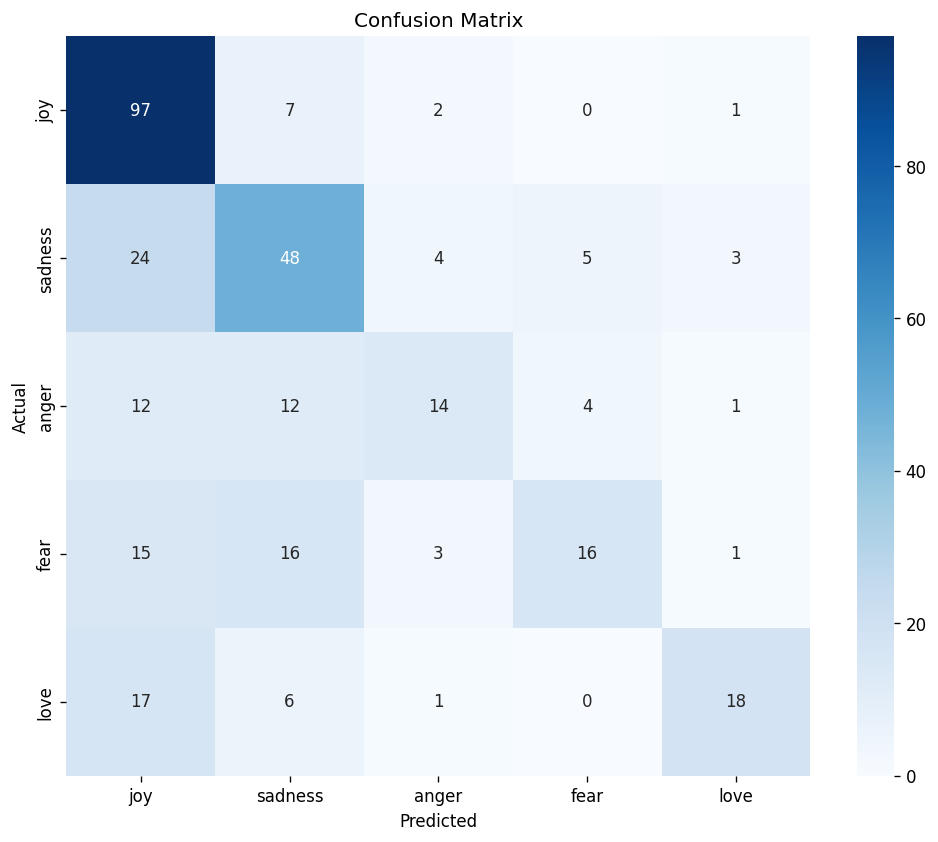

In [39]:
# 7. 评估测试集
y_pred = best_rf.predict(X_test)  # 修改变量名为y_pred
print("\n随机森林测试集分类报告:")
print(classification_report(
    y_test_encoded,  # 使用已定义的y_test_encoded
    y_pred,          # 使用新预测的y_pred
    target_names=label_names,
    digits=3
))

# 8. 可视化混淆矩阵
conf_mat = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8), dpi=120)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=['joy', 'sadness', 'anger', 'fear', 'love'],
    digits=3
))

NameError: name 'y_true' is not defined

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 1. 定义标签名称（必须与LabelEncoder顺序一致）
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']  # 替换为您的实际标签

# 2. 计算类别权重（更精细控制）
class_weights = {}
total_samples = len(y_train_encoded)
for cls in np.unique(y_train_encoded):
    cls_samples = sum(y_train_encoded == cls)
    # 权重与样本数成反比，并手动增强少数类
    weight = (total_samples / (len(np.unique(y_train_encoded)) * cls_samples))
    if cls == label_names.index('love'):  # 假设'love'是少数类
        weight *= 2.5  # 额外增强
    class_weights[cls] = weight

print("\n类别权重分配：")
for cls, weight in class_weights.items():
    print(f"{label_names[cls]}: {weight:.2f}")

# 3. 构建神经网络模型
def build_model(input_shape, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    # 自定义加权损失函数（可选）
    def weighted_loss(y_true, y_pred):
        weights = tf.gather(list(class_weights.values()), tf.cast(y_true, tf.int32))
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return loss * weights

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=weighted_loss,  # 或直接使用'sparse_categorical_crossentropy'
        metrics=['accuracy',
                tf.keras.metrics.SparseCategoricalAccuracy(name='balanced_acc'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return model

# 4. 初始化模型
model = build_model(input_shape=(X_train.shape[1],), n_classes=len(label_names))
model.summary()

# 5. 训练配置
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 6. 模型训练（使用验证集）
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded) if 'X_val' in locals() else None,
    epochs=100,
    batch_size=64,
    class_weight=class_weights,  # 应用类别权重
    callbacks=[early_stop],
    verbose=1
)

# 7. 训练过程可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['balanced_acc'], label='Train Acc')
plt.plot(history.history['val_balanced_acc'], label='Validation Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# 8. 测试集评估
y_pred_nn = model.predict(X_test).argmax(axis=-1)
print("\n神经网络测试集分类报告:")
print(classification_report(
    y_test_encoded,
    y_pred_nn,
    target_names=label_names,
    digits=3
))

# 9. 各类别详细分析
print("\n各类别表现对比:")
for cls, name in enumerate(label_names):
    cls_mask = (y_test_encoded == cls)
    if sum(cls_mask) > 0:
        precision = precision_score(y_test_encoded, y_pred_nn, labels=[cls], average='micro')
        recall = recall_score(y_test_encoded, y_pred_nn, labels=[cls], average='micro')
        print(f"{name}: Precision={precision:.3f}, Recall={recall:.3f}, Samples={sum(cls_mask)}")

# 10. 保存模型
model.save('emotion_classifier_nn.h5')


类别权重分配：
joy: 0.57
sadness: 0.81
anger: 1.35
fear: 1.30
love: 4.88


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,637 (522.02 KB)

 Trainable params: 132,869 (519.02 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node UnsortedSegmentSum_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-49-eb6f86bd4ce3>", line 66, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 84, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/usr/local/lib/python3.11/dist-packages/keras/src/metrics/confusion_metrics.py", line 1376, in update_state

  File "/usr/local/lib/python3.11/dist-packages/keras/src/metrics/metrics_utils.py", line 481, in update_confusion_matrix_variables

  File "/usr/local/lib/python3.11/dist-packages/keras/src/metrics/metrics_utils.py", line 277, in _update_confusion_matrix_variables_optimized

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/math.py", line 86, in segment_sum

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/math.py", line 23, in segment_sum

data.shape = [64] does not start with segment_ids.shape = [320]
	 [[{{node UnsortedSegmentSum_1}}]] [Op:__inference_multi_step_on_iterator_19676]

In [50]:
from sklearn.preprocessing import LabelEncoder

# 1. 标签编码
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 确保验证集存在
if "val_texts" in locals() and val_texts is not None:
    y_val_encoded = label_encoder.transform(y_val)
    validation_data = (X_val, y_val_encoded)
else:
    validation_data = None

# 2. 定义标签名称（从数据集中获取唯一标签）
label_names = label_encoder.classes_
print("检测到的标签类别:", label_names)

# 3. 计算类别权重
class_weights = {}
total_samples = len(y_train_encoded)
for cls in np.unique(y_train_encoded):
    cls_samples = sum(y_train_encoded == cls)
    weight = (total_samples / (len(np.unique(y_train_encoded)) * cls_samples))
    class_weights[cls] = weight

print("\n类别权重分配：")
for cls, weight in class_weights.items():
    print(f"{label_names[cls]}: {weight:.2f}")

# 4. 构建模型（保持您的原始模型结构）
def build_model(input_shape, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 5. 初始化模型
model = build_model(input_shape=(X_train.shape[1],), n_classes=len(label_names))
model.summary()

# 6. 训练配置
early_stop = EarlyStopping(
    monitor='val_loss' if validation_data else 'loss',
    patience=10,
    restore_best_weights=True
)

# 7. 模型训练
history = model.fit(
    X_train, y_train_encoded,
    validation_data=validation_data,
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# 8. 评估模型
if X_test is not None:
    y_pred = model.predict(X_test).argmax(axis=-1)
    print("\n测试集分类报告:")
    print(classification_report(
        y_test_encoded,
        y_pred,
        target_names=label_names,
        digits=3
    ))

检测到的标签类别: [0 1 2 3 4]

类别权重分配：
0: 0.57
1: 0.81
2: 1.35
3: 1.30
4: 1.95


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,637 (522.02 KB)

 Trainable params: 132,869 (519.02 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2836 - loss: 1.9989 - val_accuracy: 0.5148 - val_loss: 1.4480
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5726 - loss: 1.0265 - val_accuracy: 0.4492 - val_loss: 1.4100
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6376 - loss: 0.8624 - val_accuracy: 0.4852 - val_loss: 1.3699
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7134 - loss: 0.6910 - val_accuracy: 0.5377 - val_loss: 1.3270
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7345 - loss: 0.6652 - val_accuracy: 0.5180 - val_loss: 1.2997
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7468 - loss: 0.6158 - val_accuracy: 0.5344 - val_loss: 1.2498
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8040 - loss: 0.4989 - val_accuracy: 0.5770 - val_loss: 1.2088
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8305 - loss: 0.4732 - val_accuracy: 0.

TypeError: object of type 'numpy.int64' has no len()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


类别分布:
 label
0    531
1    378
3    234
2    225
4    156
Name: count, dtype: int64


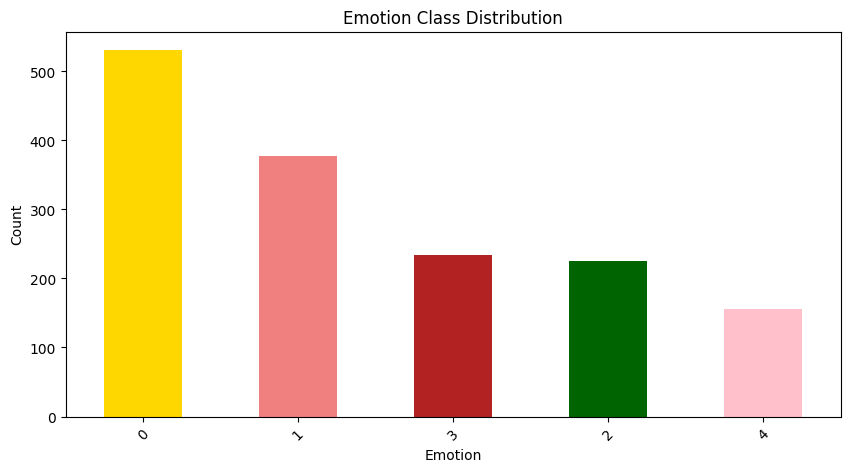

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np

# 加载数据集
dataset = load_dataset("nanaaaa/BilingualChildEmo")
train_data = dataset["train"].to_pandas()

# 查看类别分布（验证您的描述）
label_counts = train_data["label"].value_counts()
print("类别分布:\n", label_counts)

# 可视化分布
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color=['gold', 'lightcoral', 'firebrick', 'darkgreen', 'pink'])
plt.title("Emotion Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [3]:
from sentence_transformers import SentenceTransformer

# 多语言SBERT嵌入
sbert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
texts = train_data["sentence"].tolist()
X = sbert.encode(texts, show_progress_bar=True)
y = train_data["label"].astype('category').cat.codes.values  # 标签转为数值

# 拆分训练集/测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import classification_report, f1_score
import pandas as pd

# 确保label_names是字符串列表（根据您的实际标签调整）
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']  # 替换为您的实际标签名

models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Random Forest": grid_rf.best_estimator_
}

# ===== 插入位置：在模型训练循环之前 =====
# 手动设置类别权重（关键修改点）
manual_weights = {
    label_names.index('joy'): 1,      # joy权重1
    label_names.index('sadness'): 1,  # sadness权重1
    label_names.index('anger'): 1.5,  # anger权重1.5
    label_names.index('fear'): 2,     # fear权重2
    label_names.index('love'): 3      # love权重最高（3）
}

# 应用到所有支持class_weight的模型
for name, model in models.items():
    if hasattr(model, 'set_params'):  # 检查模型是否支持参数设置
        try:
            model.set_params(class_weight=manual_weights)
            print(f"✅ 已为 {name} 设置手动权重")
        except Exception as e:
            print(f"⚠️ {name} 不支持class_weight: {str(e)}")
# ===== 插入结束 =====

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": report['accuracy'],
        "F1-micro": f1_score(y_test, y_pred, average='micro'),
        "F1-macro": f1_score(y_test, y_pred, average='macro'),
        "F1-weighted": f1_score(y_test, y_pred, average='weighted')
    })

# ...（其余代码保持不变）...

✅ 已为 Logistic Regression 设置手动权重
✅ 已为 SVM 设置手动权重
✅ 已为 Random Forest 设置手动权重


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 参数网格（包含类别权重）
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None, manual_weights],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

lr = LogisticRegression(multi_class='multinomial')
grid_lr = GridSearchCV(lr, param_grid, cv=5, scoring='f1_weighted')
grid_lr.fit(X_train, y_train)

print("最佳参数:", grid_lr.best_params_)
print("加权F1:", grid_lr.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

最佳参数: {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'solver': 'lbfgs'}
加权F1: 0.6194917545203386


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [20]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# 使用SMOTE过采样
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None, manual_weights]
}

svm = SVC(probability=True)
grid_svm = GridSearchCV(svm, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_svm.fit(X_resampled, y_resampled)

print("最佳参数:", grid_svm.best_params_)

最佳参数: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [22]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', manual_weights]
}

rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted')
grid_rf.fit(X_train, y_train)

print("最佳参数:", grid_rf.best_params_)

最佳参数: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}


In [8]:
from sklearn.metrics import classification_report, f1_score
import pandas as pd

# 确保label_names是字符串列表（根据您的实际标签调整）
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']  # 替换为您的实际标签名

models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Random Forest": grid_rf.best_estimator_
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": report['accuracy'],
        "F1-micro": report['macro avg']['f1-score'],  # 注意：这里实际是macro
        "F1-macro": f1_score(y_test, y_pred, average='macro'),
        "F1-weighted": f1_score(y_test, y_pred, average='weighted')
    })

# 结果表格
results_df = pd.DataFrame(results)
print("模型总体性能比较:")
print(results_df.sort_values("F1-weighted", ascending=False))

# 各类别详细性能
print("\n=== 各类别详细性能 ===")
for name, model in models.items():
    print(f"\n🔍 {name} 各类别性能:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_names, digits=3))

模型总体性能比较:
                 Model  Accuracy  F1-micro  F1-macro  F1-weighted
1                  SVM  0.678689  0.641655  0.641655     0.674776
0  Logistic Regression  0.645902  0.604986  0.604986     0.638970
2        Random Forest  0.609836  0.528929  0.528929     0.580461

=== 各类别详细性能 ===

🔍 Logistic Regression 各类别性能:
              precision    recall  f1-score   support

         joy      0.724     0.840     0.777       106
     sadness      0.560     0.618     0.588        76
       anger      0.650     0.578     0.612        45
        fear      0.538     0.447     0.488        47
        love      0.737     0.452     0.560        31

    accuracy                          0.646       305
   macro avg      0.642     0.587     0.605       305
weighted avg      0.645     0.646     0.639       305


🔍 SVM 各类别性能:
              precision    recall  f1-score   support

         joy      0.750     0.821     0.784       106
     sadness      0.633     0.658     0.645        76
       anger 

各模型在不同情感类别上的分类正确率：
         Logistic Regression    SVM  Random Forest
joy                    0.840  0.821          0.868
sadness                0.618  0.658          0.658
anger                  0.578  0.667          0.578
fear                   0.447  0.532          0.191
love                   0.452  0.484          0.290


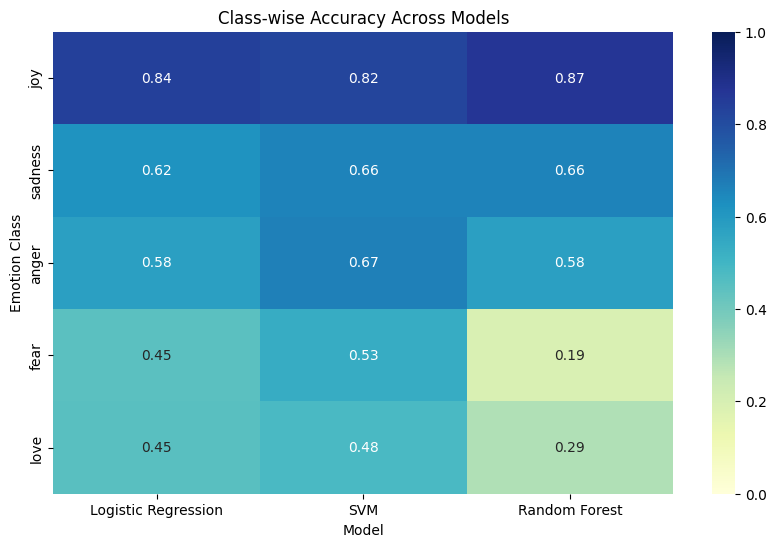

In [14]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# 定义情感标签（确保与您的数据一致）
label_names = ['joy', 'sadness', 'anger', 'fear', 'love']

# 准备存储结果的DataFrame
class_accuracies = pd.DataFrame(index=label_names)

for model_name, model in models.items():
    y_pred = model.predict(X_test)

    # 计算每个类别的accuracy
    acc_per_class = []
    for cls in range(len(label_names)):
        # 获取当前类别的样本索引
        cls_idx = (y_test == cls)
        if sum(cls_idx) > 0:  # 确保类别存在
            acc = accuracy_score(y_test[cls_idx], y_pred[cls_idx])
        else:
            acc = np.nan
        acc_per_class.append(acc)

    # 添加到结果DataFrame
    class_accuracies[model_name] = acc_per_class

# 打印结果
print("各模型在不同情感类别上的分类正确率：")
print(class_accuracies.round(3))

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(class_accuracies, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Class-wise Accuracy Across Models")
plt.ylabel("Emotion Class")
plt.xlabel("Model")
plt.show()

In [9]:

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 为每个模型计算各类别的详细指标
def get_class_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })
    return metrics_df

# 2. 收集所有模型的详细指标
all_metrics = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    class_metrics = get_class_metrics(y_test, y_pred, label_counts.index)
    class_metrics['Model'] = name
    all_metrics.append(class_metrics)

# 合并结果
full_metrics = pd.concat(all_metrics)

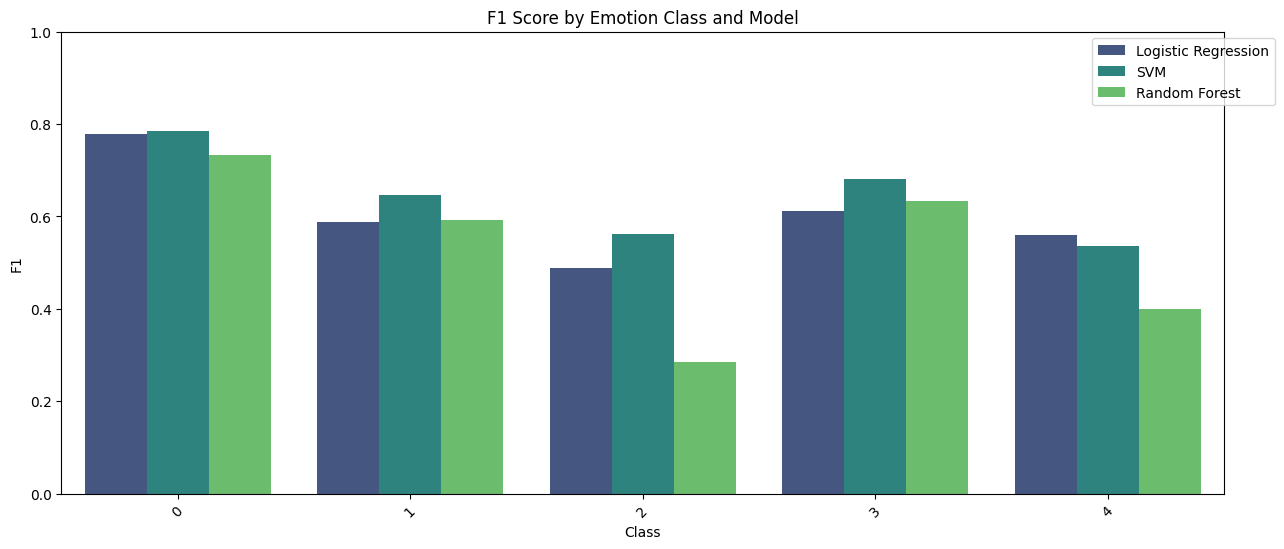

In [10]:
# 3. 可视化每个模型在各类别的F1分数
plt.figure(figsize=(15, 6))
sns.barplot(data=full_metrics, x='Class', y='F1', hue='Model', palette='viridis')
plt.title("F1 Score by Emotion Class and Model")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

In [11]:
# 4. 表格形式输出每个类别详细指标
print("\n=== 各类别详细性能 ===")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(full_metrics.sort_values(['Class', 'F1'], ascending=[True, False]))



=== 各类别详细性能 ===
   Class  Precision    Recall        F1                Model
0      0   0.750000  0.820755  0.783784                  SVM
0      0   0.723577  0.839623  0.777293  Logistic Regression
0      0   0.634483  0.867925  0.733068        Random Forest
1      1   0.632911  0.657895  0.645161                  SVM
1      1   0.537634  0.657895  0.591716        Random Forest
1      1   0.559524  0.618421  0.587500  Logistic Regression
3      2   0.595238  0.531915  0.561798                  SVM
3      2   0.538462  0.446809  0.488372  Logistic Regression
3      2   0.562500  0.191489  0.285714        Random Forest
2      3   0.697674  0.666667  0.681818                  SVM
2      3   0.702703  0.577778  0.634146        Random Forest
2      3   0.650000  0.577778  0.611765  Logistic Regression
4      4   0.736842  0.451613  0.560000  Logistic Regression
4      4   0.600000  0.483871  0.535714                  SVM
4      4   0.642857  0.290323  0.400000        Random Forest


<ipython-input-12-1c699a9d7a21>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1))


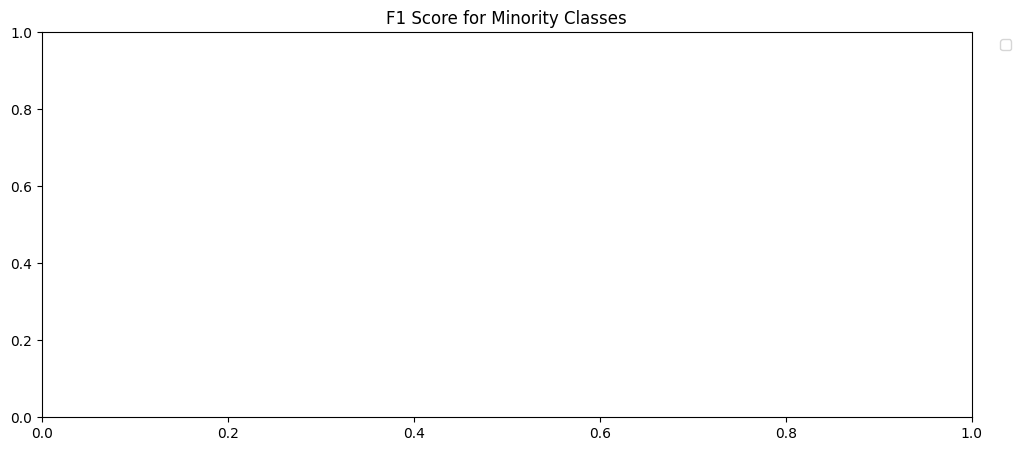


🔍 Logistic Regression 详细分类报告:


TypeError: object of type 'int' has no len()

In [12]:
# 5. 重点少数类（LOVE/FEAR）对比
minority_classes = ['love', 'fear']  # 根据您的实际标签名称调整
minority_df = full_metrics[full_metrics['Class'].isin(minority_classes)]

plt.figure(figsize=(12, 5))
sns.barplot(data=minority_df, x='Model', y='F1', hue='Class', palette='coolwarm')
plt.title("F1 Score for Minority Classes")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# 6. 输出格式优化后的分类报告
for name, model in models.items():
    print(f"\n🔍 {name} 详细分类报告:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_counts.index, digits=3))